In [1]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
os.environ['ENABLE_JSON_LOGGING'] = 'true'
os.environ['LOGLEVEL'] = 'INFO'

In [4]:
import waterhealer as wh
import json
import logging

wh.__version__

'0.1.6'

In [5]:
brokers = 'localhost:29092'

In [6]:
source = wh.from_kafka(
    ['testing'],
    {
        'bootstrap.servers': brokers,
        'group.id': 'group-test-3',
        'auto.offset.reset': 'latest',
    },
)

{"written_at": "2022-01-25T05:27:16.102Z", "written_ts": 1643088436102593000, "msg": "Use waterhealer.db.expiringdict.DictHealer with max_len=10000000, max_age_seconds=3600", "type": "log", "logger": "root", "thread": "MainThread", "level": "INFO", "module": "kafka", "line_no": 40, "function_name": null, "emit_id": null}


In [7]:
def json_loads(row):
    return (row[0], json.loads(row[1]))

def plus(row, m = 30):
    no = row[1]['no']
    logging.info(f'plus {no}')
    if no > m:
        raise Exception(f'{row}, {no} is bigger than {m}')
    return (row[0], no + 1)

In [8]:
outputs = []
h = source.map(json_loads).map(plus).healing(interval = 5)
h.sink(outputs.append)

Output()

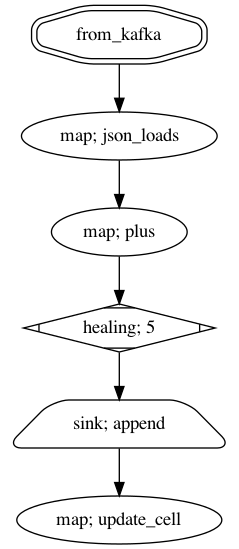

In [9]:
source.visualize()

In [10]:
source.start()

In [11]:
outputs

[]

In [12]:
from kafka import KafkaProducer
from kafka.partitioner import RoundRobinPartitioner

In [13]:
producer = KafkaProducer(
    bootstrap_servers = brokers.split(','),
    api_version = (0, 10),
    partitioner = RoundRobinPartitioner(),
)

{"written_at": "2022-01-25T05:27:19.238Z", "written_ts": 1643088439238310000, "msg": "<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: connecting to localhost:29092 [('::1', 29092, 0, 0) IPv6]", "type": "log", "logger": "kafka.conn", "thread": "kafka-python-producer-1-network-thread", "level": "INFO", "module": "conn", "line_no": 374, "function_name": null, "emit_id": null}
{"written_at": "2022-01-25T05:27:19.241Z", "written_ts": 1643088439241132000, "msg": "<BrokerConnection node_id=bootstrap-0 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: Connection complete.", "type": "log", "logger": "kafka.conn", "thread": "kafka-python-producer-1-network-thread", "level": "INFO", "module": "conn", "line_no": 403, "function_name": null, "emit_id": null}


In [14]:
producer.bootstrap_connected()

True

In [15]:
from datetime import datetime
import json

def publish_message(producer_instance, topic_name, key, value):
    try:
        key_bytes = bytes(key, encoding = 'utf-8')
        value_bytes = bytes(value, encoding = 'utf-8')
        x = producer_instance.send(topic_name, value = value_bytes)
        return True
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))
        return False

{"written_at": "2022-01-25T05:27:22.744Z", "written_ts": 1643088442744544000, "msg": "healing successful: False, 2022-01-25 13:27:22.744391", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "healing", "line_no": 92, "function_name": "healing", "emit_id": null}


## purposely raise the error

Based on function `plus`, if input bigger than 30, it will throw error.

In [16]:
import time

for count in range(35):
    data = {'no': count, 'datetime': str(datetime.now())}
    print(data)
    publish_message(
        producer, 'testing', 'streaming', json.dumps(data)
    )
    time.sleep(0.1)

{'no': 0, 'datetime': '2022-01-25 13:27:22.817597'}
{"written_at": "2022-01-25T05:27:22.819Z", "written_ts": 1643088442819942000, "msg": "<BrokerConnection node_id=1 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: connecting to localhost:29092 [('::1', 29092, 0, 0) IPv6]", "type": "log", "logger": "kafka.conn", "thread": "kafka-python-producer-1-network-thread", "level": "INFO", "module": "conn", "line_no": 374, "function_name": null, "emit_id": null}
{"written_at": "2022-01-25T05:27:22.821Z", "written_ts": 1643088442821996000, "msg": "<BrokerConnection node_id=1 host=localhost:29092 <connecting> [IPv6 ('::1', 29092, 0, 0)]>: Connection complete.", "type": "log", "logger": "kafka.conn", "thread": "kafka-python-producer-1-network-thread", "level": "INFO", "module": "conn", "line_no": 403, "function_name": null, "emit_id": null}
{"written_at": "2022-01-25T05:27:22.823Z", "written_ts": 1643088442823509000, "msg": "<BrokerConnection node_id=bootstrap-0 host=localhost:29092 

{"written_at": "2022-01-25T05:27:23.305Z", "written_ts": 1643088443305110000, "msg": "{'function_name': 'map.plus', 'data': \"({'partition': 4, 'offset': 15, 'topic': 'testing'}, 5)\"}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "cb9023f3-b752-451a-a077-2c83261c95aa"}
{'no': 5, 'datetime': '2022-01-25 13:27:23.331815'}
{"written_at": "2022-01-25T05:27:23.406Z", "written_ts": 1643088443406664000, "msg": "{'function_name': 'from_kafka', 'data': '({\\'partition\\': 5, \\'offset\\': 13, \\'topic\\': \\'testing\\'}, b\\'{\"no\": 5, \"datetime\": \"2022-01-25 13:27:23.331815\"}\\')'}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "beab0f1e-4553-4852-9011-b52141b4cb6d"}
{"written_at": "2022-01-25T05:27:23.407Z", "written_ts": 1643088443407332000, "msg": "{'function_name': 'map.json_loads', 'data': \"({'partition': 5, 'offset': 13, 'topic': 'testing

{"written_at": "2022-01-25T05:27:23.940Z", "written_ts": 1643088443940622000, "msg": "{'function_name': 'map.json_loads', 'data': \"({'partition': 0, 'offset': 16, 'topic': 'testing'}, {'no': 10, 'datetime': '2022-01-25 13:27:23.844394'})\"}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "73cff252-5fc6-4330-bc5e-07133702c71e"}
{"written_at": "2022-01-25T05:27:23.941Z", "written_ts": 1643088443941218000, "msg": "plus 10", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "<ipython-input-7-21dc689e6362>", "line_no": 6, "function_name": "map.plus", "emit_id": "73cff252-5fc6-4330-bc5e-07133702c71e"}
{"written_at": "2022-01-25T05:27:23.941Z", "written_ts": 1643088443941893000, "msg": "{'function_name': 'map.plus', 'data': \"({'partition': 0, 'offset': 16, 'topic': 'testing'}, 11)\"}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547,

{"written_at": "2022-01-25T05:27:24.383Z", "written_ts": 1643088444383362000, "msg": "{'function_name': 'map.plus', 'data': \"({'partition': 5, 'offset': 14, 'topic': 'testing'}, 16)\"}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "cfe63635-f43b-45bf-b645-7f9a4951f56c"}
{'no': 16, 'datetime': '2022-01-25 13:27:24.465158'}
{"written_at": "2022-01-25T05:27:24.488Z", "written_ts": 1643088444488047000, "msg": "{'function_name': 'from_kafka', 'data': '({\\'partition\\': 6, \\'offset\\': 14, \\'topic\\': \\'testing\\'}, b\\'{\"no\": 16, \"datetime\": \"2022-01-25 13:27:24.465158\"}\\')'}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "4a56fa05-cd31-48e6-b0a2-b89ee4d5369c"}
{"written_at": "2022-01-25T05:27:24.488Z", "written_ts": 1643088444488784000, "msg": "{'function_name': 'map.json_loads', 'data': \"({'partition': 6, 'offset': 14, 'topic': 'test

{"written_at": "2022-01-25T05:27:25.015Z", "written_ts": 1643088445015973000, "msg": "{'function_name': 'map.json_loads', 'data': \"({'partition': 1, 'offset': 17, 'topic': 'testing'}, {'no': 21, 'datetime': '2022-01-25 13:27:24.974956'})\"}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "77e9e1aa-3953-484d-9f1e-ac5a87b8f0ad"}
{"written_at": "2022-01-25T05:27:25.016Z", "written_ts": 1643088445016471000, "msg": "plus 21", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "<ipython-input-7-21dc689e6362>", "line_no": 6, "function_name": "map.plus", "emit_id": "77e9e1aa-3953-484d-9f1e-ac5a87b8f0ad"}
{"written_at": "2022-01-25T05:27:25.017Z", "written_ts": 1643088445017017000, "msg": "{'function_name': 'map.plus', 'data': \"({'partition': 1, 'offset': 17, 'topic': 'testing'}, 22)\"}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547,

{"written_at": "2022-01-25T05:27:25.542Z", "written_ts": 1643088445542867000, "msg": "{'function_name': 'map.plus', 'data': \"({'partition': 6, 'offset': 15, 'topic': 'testing'}, 27)\"}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "c0bc731a-7858-4150-80c6-490eaaad5b3e"}
{'no': 27, 'datetime': '2022-01-25 13:27:25.592487'}
{"written_at": "2022-01-25T05:27:25.644Z", "written_ts": 1643088445644173000, "msg": "{'function_name': 'from_kafka', 'data': '({\\'partition\\': 7, \\'offset\\': 15, \\'topic\\': \\'testing\\'}, b\\'{\"no\": 27, \"datetime\": \"2022-01-25 13:27:25.592487\"}\\')'}", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "core", "line_no": 547, "emit_id": "7ad4b54c-295b-477b-9751-4de47707670d"}
{"written_at": "2022-01-25T05:27:25.645Z", "written_ts": 1643088445645242000, "msg": "{'function_name': 'map.json_loads', 'data': \"({'partition': 7, 'offset': 15, 'topic': 'test

{"written_at": "2022-01-25T05:27:26.073Z", "written_ts": 1643088446073433000, "msg": "Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x12c18bef0>, <Future finished exception=Exception(\"({'partition': 1, 'offset': 18, 'topic': 'testing'}, {'no': 31, 'datetime': '2022-01-25 13:27:26.002842'}), 31 is bigger than 30\")>)", "type": "log", "logger": "tornado.application", "thread": "Thread-4", "level": "ERROR", "module": "ioloop", "line_no": 801, "function_name": null, "emit_id": null}


{'no': 32, 'datetime': '2022-01-25 13:27:26.106586'}
{'no': 33, 'datetime': '2022-01-25 13:27:26.209042'}
{'no': 34, 'datetime': '2022-01-25 13:27:26.309821'}


In [19]:
offsets = source.consumer.committed(source.consumer.assignment())
lags = {}
for offset in offsets:
    _, high_offset = source.consumer.get_watermark_offsets(offset)
    lags[offset.partition] = high_offset - offset.offset
lags

{"written_at": "2022-01-25T05:27:42.481Z", "written_ts": 1643088462481437000, "msg": "healing successful: False, 2022-01-25 13:27:42.481339", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "healing", "line_no": 92, "function_name": "healing", "emit_id": null}


{0: 0, 1: 2, 2: 1, 3: 1, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [20]:
sum(lags.values()) > 0

True

{"written_at": "2022-01-25T05:27:47.545Z", "written_ts": 1643088467545164000, "msg": "healing successful: False, 2022-01-25 13:27:47.545069", "type": "log", "logger": "root", "thread": "Thread-4", "level": "INFO", "module": "healing", "line_no": 92, "function_name": "healing", "emit_id": null}
